In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import collections
import PIL

import scipy
import sklearn
import sklearn.metrics
from sklearn.pipeline import Pipeline

import math

import sys
import logging 
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger("py.warnings").setLevel(logging.ERROR)

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
np.__version__

'1.12.0'

In [154]:
import general
import simpsons
from general.plotting import gridplot

In [155]:
config = dict(
    training_img_shape=(202,360),     # 1/4 of HD image
    test_img_shape=(202,360),         # ...
)

In [156]:
import gzip
import pickle

with gzip.GzipFile("data/dataset.pickle.zip", "r") as f:
    data = pickle.load(f)

In [157]:
print("train images by char: ", data.train.y.sum(axis=0))
print("train_dev images by char: ", data.train_dev.y.sum(axis=0))
print("dev  images by char: ", data.dev.y.sum(axis=0))
print("test images by char: ", data.test.y.sum(axis=0))
data.show()

train images by char:  [ 91.  79.  64.  37.]
train_dev images by char:  [ 30.  26.  22.  12.]
dev  images by char:  [  74.  101.   66.   65.]
test images by char:  [  73.  102.   64.   64.]
train
  - X: (474, 200, 200, 3)
  - y: (474, 4)
train_dev
  - X: (158, 200, 200, 3)
  - y: (158, 4)
dev
  - X: (351, 202, 360, 3)
  - y: (351, 4)
test
  - X: (351, 202, 360, 3)
  - y: (351, 4)


In [158]:
%store -r background_images
if 'background_images' not in vars(): 
    frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
        background_videoclips_path="data/preprocessing/training/backgrounds",
        background_required_num=100, 
        background_output_shape=config['training_img_shape'],
    )
    background_images = frame_generator.background_images
    %store background_images    
    
    import pickle
    import gzip
    import time

    with gzip.GzipFile("data/background_images.pickle.zip", 'wb') as f:
        pickle.dump(background_images, f)

In [215]:
%autoreload
import simpsons
import imp
imp.reload(simpsons.preprocessing)
frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(background_images=background_images)

In [216]:
imgs, ys = data.train.X, data.train.y

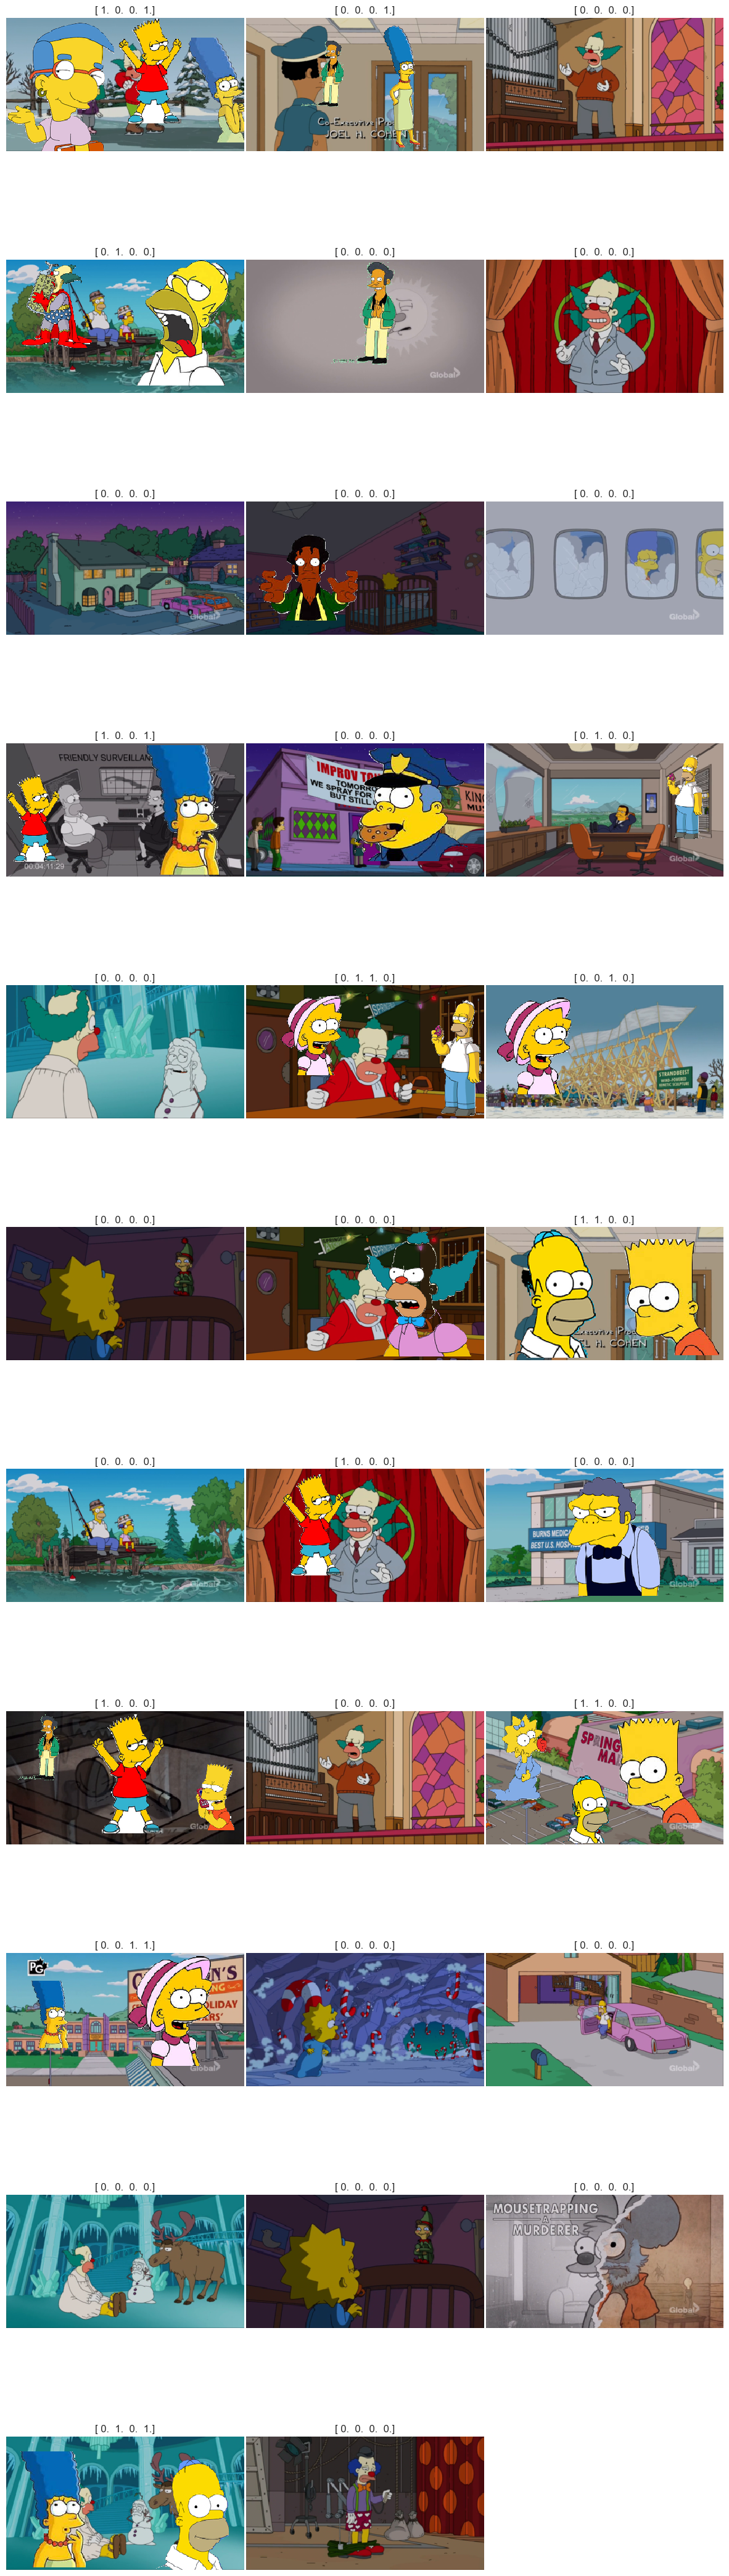

In [217]:
g = frame_generator.generate(imgs, ys, max_num_characters=3, num_characters_probs=[0.5,0.2,0.2,0.1], batch_size=32,
                             output_shape=config['training_img_shape'], train_shape_range=[0.5,1.0])
gen_imgs, gen_labels = next(g)
gridplot(gen_imgs, titles=gen_labels, num_cols=3)
#print(gen_imgs.shape)

In [214]:
import decimal
np.array([0.5,0.2,0.2,0.1]).astype(decimal.Decimal).sum()

0.9999999999999999

In [9]:
import keras
import keras.applications
import keras.preprocessing.image
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *

from keras.layers import *

def create_model(opt='adam', fc_detectors=[], train_all=False, batchnorm=True, dropout=0.5, base_output_layer='block5_pool', num_detectors=16, num_outputs=4):
    if type(base_output_layer) is int:
        base_output_layer = "block{}_pool".format(base_output_layer)

    unknown_img_size_inp = Input(shape=(None,None,3), name='input')
    vgg = keras.applications.vgg16.VGG16(include_top=False)
    base_model = Model(input=vgg.input, output=vgg.get_layer(base_output_layer).output)
    
    base_model_output = x = base_model(unknown_img_size_inp)
    
    if batchnorm:
        x = BatchNormalization(name='bn')(x)
    x = Dropout(dropout, name="dropout")(x)

    for ind, fc_det in enumerate(fc_detectors):
        x = Convolution2D(fc_det, 1, 1, name="fc_detector_{}".format(ind))(x)
    
    x = Convolution2D(num_detectors,1,1, name='detectors_spatial')(x)
    x = GlobalMaxPooling2D(name='detectors')(x)
    
    x = Dense(num_outputs, name='output', activation='sigmoid')(x)
       
    model = Model(input=unknown_img_size_inp, output=x) 
    
    # Compile model    
    if not train_all:
        for l in base_model.layers:
            l.trainable = False
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'accuracy'])
    return model


In [ ]:
%autoreload

frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(background_images=background_images)

build_params = [
    {
        'num_outputs': [4], 
        'num_detectors': [64],
    }
]
generator_params = [
    {
        'batch_size': [32],
        'output_shape': [ config['training_img_shape'] ],
        'num_characters': [2,3],
        'train_shape_range': [[0.6,1.0]],
    }
]

gch = general.dl.DLGridSearch(create_model, build_params=build_params,
                generator_fn=frame_generator.generate, generator_params=generator_params)

gch.fit(data.train.X, data.train.y, data.train_dev.X, data.train_dev.y, nb_epoch=100)

In [84]:
def trim_nan_edges(img):
    img_char_mask = np.argwhere(~np.isnan(img).all(axis=2))
    ti_r_s, ti_r_e = img_char_mask[:,0].min(), img_char_mask[:,0].max()
    ti_c_s, ti_c_e = img_char_mask[:,1].min(), img_char_mask[:,1].max()
    return img[ti_r_s:ti_r_e, ti_c_s:ti_c_e]


In [129]:
bg_img = background_images[45]
train_images = [ trim_nan_edges(img) for img in data.train.X[np.random.choice(range(data.train.X.shape[0]), 4, replace=False)] ]



In [139]:
def patch_images_on_background(bg, images):
    bg = bg.copy()
    print("got images: ", [i.shape for i in images])

    images_widths = np.array([0] + [ img.shape[1] for img in images ])
    images_bnds = np.cumsum(images_widths) / images_widths.sum() * bg.shape[1]  # calc right end of images scaled to bg size
    images_bnds = images_bnds.astype(int)

    print("bg.shape - ", bg.shape)
    print("images_bnds - ", images_bnds)
    for i in range(len(images)):
        print("\nimage ", i)
        
        img = images[i]
        
        # horizontal
        img_start = images_bnds[i]
        img_end = images_bnds[i+1]
        if img_start + img.shape[1] >= bg.shape[1]:
            img_start = bg.shape[1] - img.shape[1]
            img_end = bg.shape[1]
        print(img_start, img_end)
        c = np.random.randint(max(1, img_end - img_start - img.shape[1] + 1)) + img_start
        
        # vertical
        r = np.random.randint(max(1, bg.shape[0] - img.shape[0] + 1))
    
        # patch it on the bg
        img_bg_indices = np.all(np.isnan(img), axis=-1)
        print("{}:{} , {}:{}".format(r, r+img.shape[0], c, c+img.shape[1]))
        bg[r:r+img.shape[0], c:c+img.shape[1], :][~img_bg_indices] = img[~img_bg_indices]
    
    return bg
    
    


got images:  [(199, 121, 3), (198, 117, 3), (166, 199, 3), (199, 120, 3)]
bg.shape -  (202, 360, 3)
images_bnds -  [  0  78 153 282 360]

image  0
0 78
2:201 , 0:121

image  1
78 153
2:200 , 78:195

image  2
153 282
32:198 , 153:352

image  3
240 360
1:200 , 240:360


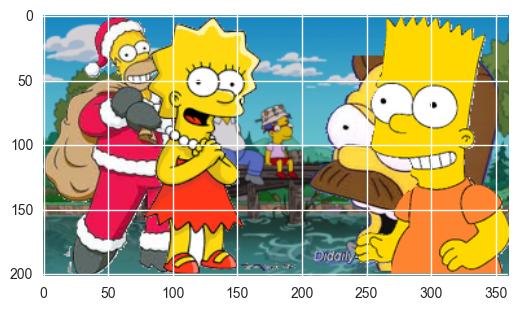

In [151]:
img = patch_images_on_background(bg_img, train_images)
plt.imshow(img)

In [145]:
0.8237986270022883*np.array((121,117,199))

array([  99.67963387,   96.38443936,  163.93592677])

In [149]:
360-161

199

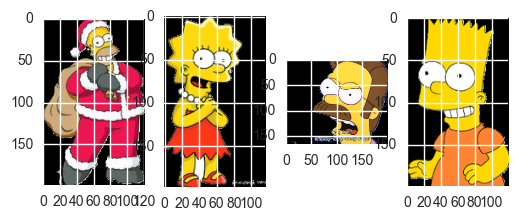

In [150]:
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(train_images[i])